# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator

/home/shusnugil/qnm_filter/qnm_filter/utility.py:24: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


## GW150914

Download data

In [3]:
 !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
 !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

--2024-12-18 13:06:07--  https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.72
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.72|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gwosc.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5 [following]
--2024-12-18 13:06:08--  https://gwosc.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
Resolving gwosc.org (gwosc.org)... 131.215.113.72
Connecting to gwosc.org (gwosc.org)|131.215.113.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068797 (3.9M) [application/octet-stream]
Saving to: ‘H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5.2’

H-H1_GWOSC_16KHZ_R1 100%[===================>]   3.88M  2.50MB/s    in 1.6s    

2024-12-18 13:06:11 (2.50 MB/s) - ‘H-H1_

Set some parameters of GW150914

In [4]:
input = dict(model_list = [(2, 2, 0, 'p')], #l, m, n, prograde/retrograde
             # trucation time (geocenter, in second)
             t_init = 1126259462.4083147+2.0*1e-3,
             # length of the analysis segment (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [5]:
fit.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5')

Perform time alignment across detectors

In [6]:
fit.detector_alignment()

Condition data 

In [7]:
fit.condition_data('original_data', **input)

Cholesky-decomposition of the covariance matrix 

In [8]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [9]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [10]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = -1, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [11]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

Plot 2d contours

Text(0, 0.5, '$\\chi_f$')

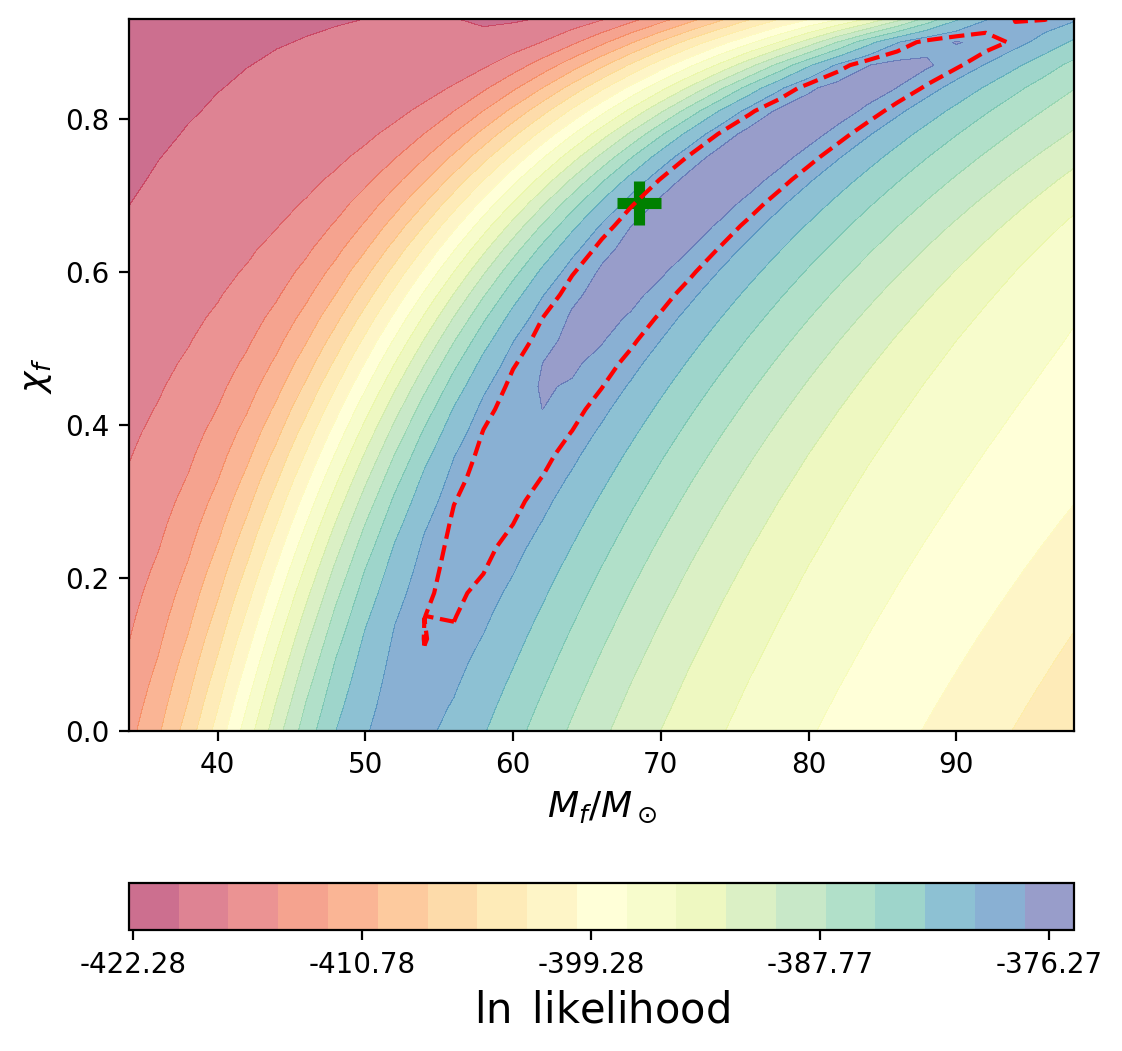

In [11]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

With 1D side plots

NameError: name 'projected_mass' is not defined

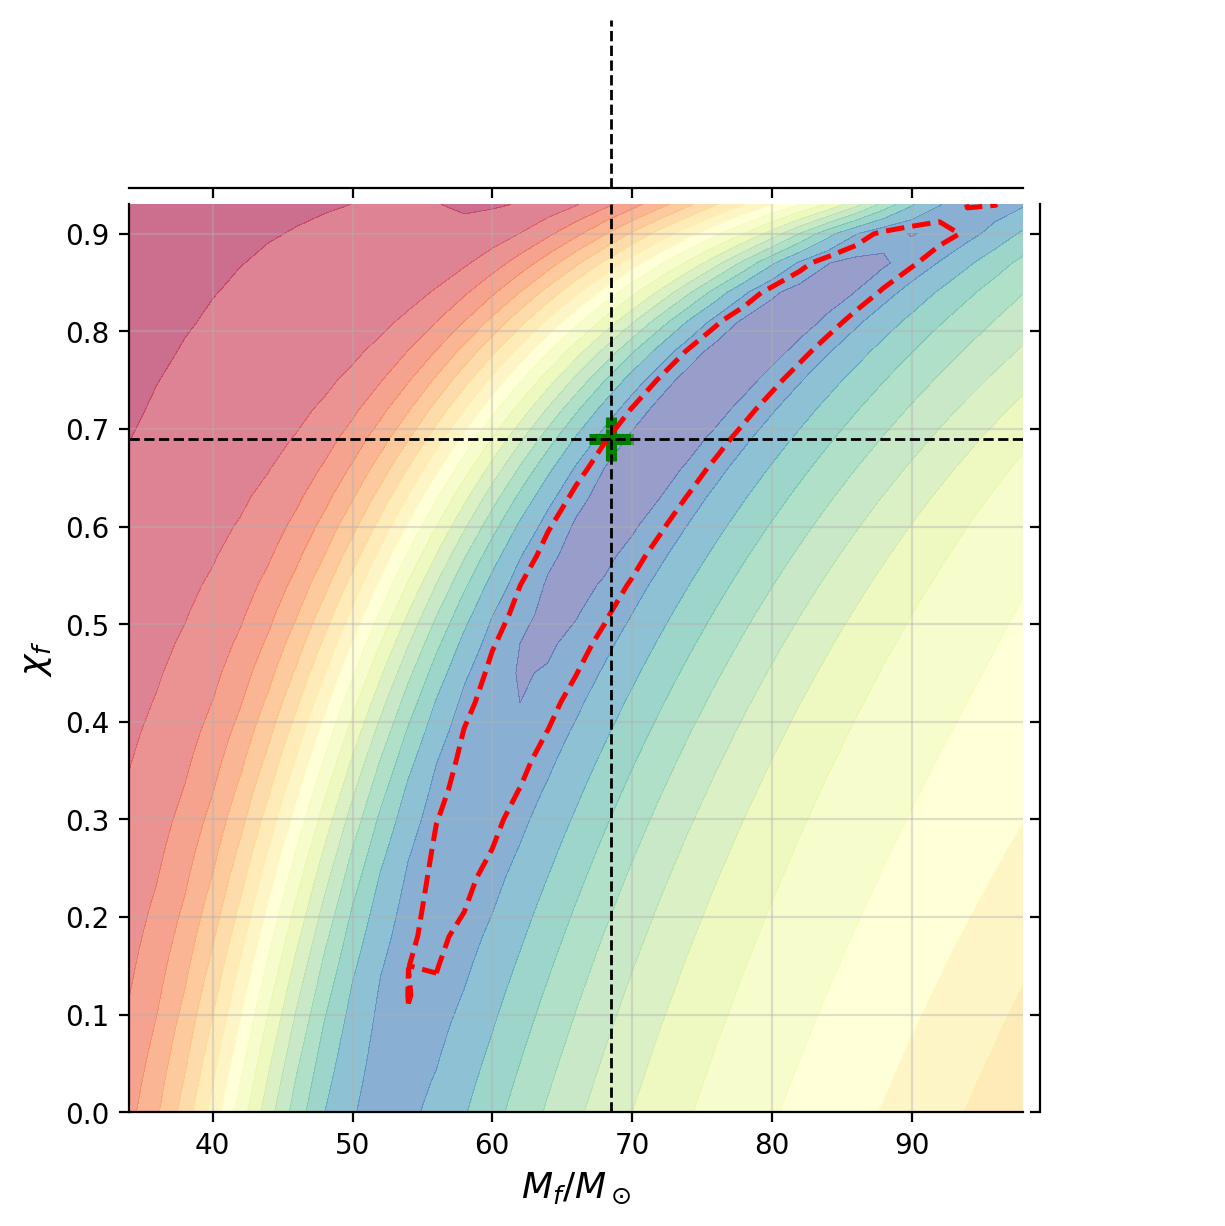

In [12]:
g = sns.JointGrid(ratio=5,space=0.1)

# 2D
contours=g.ax_joint.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
g.ax_joint.contour(contours, levels=[credible_region], linewidths=1.8,
                   linestyles='--', colors='red')
g.ax_joint.xaxis.set_major_locator(MultipleLocator(10))
g.ax_joint.yaxis.set_major_locator(MultipleLocator(0.1))
g.ax_joint.scatter(x=68.5, y=0.69, s=255, marker='+', 
                   c='g', linewidths=4, label='IMR')
g.ax_joint.axvline(68.5, ls='--', lw=1, c='k')
g.ax_joint.axhline(0.69, ls='--', lw=1, c='k')
g.ax_joint.set_xlabel(r'$M_f/M_\odot$', fontsize=13)
g.ax_joint.set_ylabel(r'$\chi_f$', fontsize=13)
g.ax_joint.grid(alpha=0.4)

# 1D side plots 
g.ax_marg_x.axvline(68.5, ls='--', lw=1, c='k')
g.ax_marg_x.plot(massspace, projected_mass, color='r', lw=1.8, alpha=0.5)

g.ax_marg_y.axhline(0.69, ls='--', lw=1, c='k')
g.ax_marg_y.plot(projected_chi, chispace, color='r',lw=1.8,alpha=0.5)

# coloarbar
divider = make_axes_locatable(g.ax_marg_y)
cax = divider.append_axes('right', size='20%', pad=0.1)
cbar=g.fig.colorbar(contours, cax=cax, orientation="vertical", format='%3.0f', ax=g.ax_marg_y)
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))